# Ising Model

In order to simulate a magnetic system that is undergoing a phase transition, I will be simplifying the problem to a 2D Ising model governed by a Hamiltonian where $\textit{J}$ is the coupling constant that determines the coupling between spins on a lattice while $\sigma_i$ and $\sigma_j$ represent the spins at their respective site $\textit{i}$ and $\textit{j}$.

For this project, I chose an $\textit{N} \times \textit{N}$ square and triangular lattice and the Monte Carlo Markov Chain (MCMC) to simulate the phase transistion as a function of average magnetization. The MCMC algorithm provides the mechanism to generate these phase diagrams.

### Monte Carlo Markov Chain (MCMC)

In order to simulate the Ising system to obtain configurations representative of
ordered and disordered states, I utilized the Metropolis algorithm and applied a
Markov process. *This method allows for an efficient survey of all possible configurations that is also consistent with equilibrium statistical mechanics*.

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Metropolis-Hastings Algorithm:

Low T $\rightarrow$ Ordered Ferromagnetic Phase $\\$
High T $\rightarrow$ Disordred Paramagnetic Phase

`metropolis_step`: function that generates one Monte Carlo sweep of the lattice and implements Metropolis-Hastings algorithm.

`delta_energy`: Metropolis acceptance criterion that flips spin based on its interaction energy with neighbors

Magnetization ($M = \sum_i {s_i}$, where each spin is $s_i = \pm 1$) is used as an order parameter to label the generated configurations as $\textit{ordered}$ or \$\textit{disordered}$.



In [43]:
temps = np.linspace(1,4,20).tolist()

def metropolis_step(config, beta):
    for i in range(N):
        for j in range(N):
            
            spin = config[i, j]
            neighbors_sum = config[(i+1)%N, j] + config[i, (j+1)%N] + config[(i-1)%N, j] + config[i, (j-1)%N]
            delta_energy = 2 * spin * neighbors_sum

            if delta_energy < 0 or np.random.rand() < np.exp(-beta * delta_energy):
                spin *= -1
            config[i, j] = spin
    return config


# Finite-Size Effects
The analytical solution to this problem is for an infinite system, which means that the configurations founding using the MCMC deal with finite-size effects. For optimal performance and reduction of finite-size effects, I performed a scaling study to see which lattice sizes have a reasonable computational cost while still *accurately* capturing the relevant physics of these systems.

Here are the results for a $4 \times 4$ square lattice versus a $40 \times 40$ square lattice:
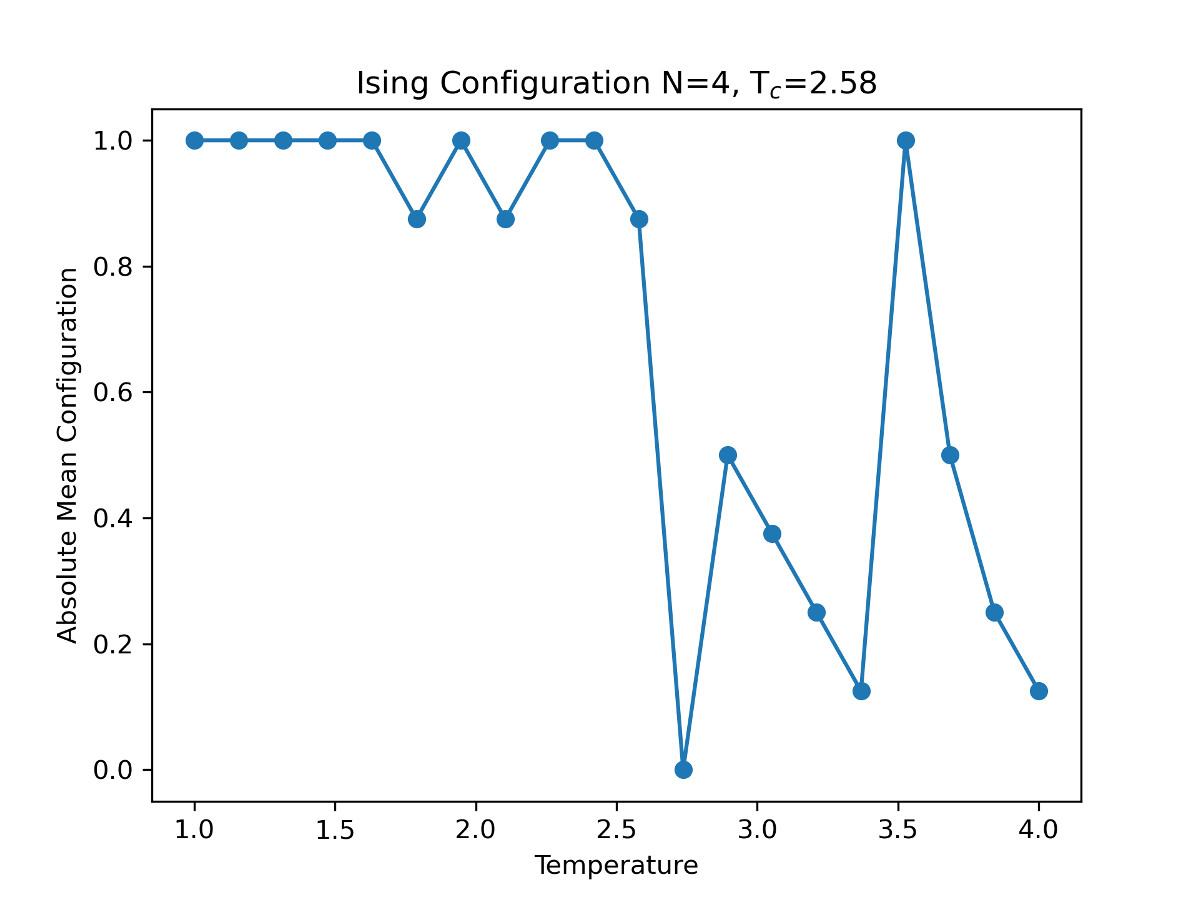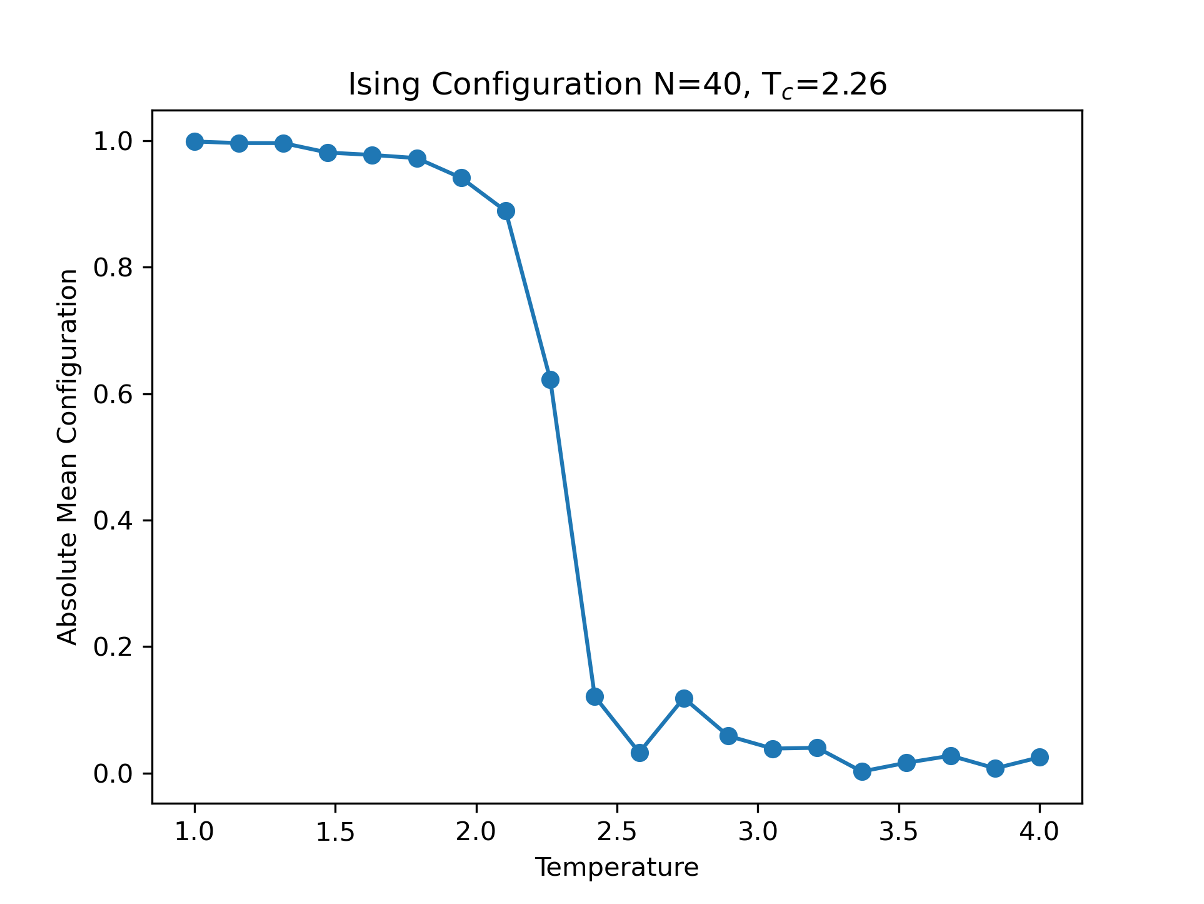

Within the Ising Model, the distinction between the ordered and disordered state can be measured via the temperature at which there is a discontinuation in the magentization. This relationship is not clear for $N=4$ since there is not a clear distinction between the two regimes due to finite-size effects. 


In [44]:
def calculate_magnetization(config):
    return np.sum(config)

def is_ordered(config, critical_temp):
    return np.abs(np.mean(config)) > 0.5 if critical_temp is None else temp <= critical_temp

N = 40  # Size of the lattice
steps = 1500  # Number of Monte Carlo steps
thermalization_steps = 600  # Thermalization steps to ensure equilibrium
num_samples_per_temp = 500  # Number of samples per temperature

### Dataset structure

`Phase`: Ordered (True), Disordered (False)

`Temperature`: Simulation Temperature

`sample_index`: Monte Carlo time index

`config`: Full spin configuration as an $\textit{N} \times \textit{N}$ lattice

In [45]:
data_dtype = [('phase', np.bool_), ('temperature', np.float64), ('sample_index', np.int32), ('config', np.int8, (N, N))]
ordered_data = []
disordered_data = []

avg_magnetization =[]
avg_config = []

### Temperature Iteration:

Performing an independent Monte Carlo calculation at each temperature that corresponds to a different statistical distribution.

`print(temp, np.abs(np.mean(config)))`: Confirms expected physical behavior (i.e low T $\rightarrow$ high M, high T $\rightarrow$ M $\approx$ 0).

`ordered_data.extend` / `disordered_data.extend`: Builds global dataset across all temperatures

 `critical_temp`: **Determines critical temperature (i.e. point of phase transition) by finding where magnetization exhibits discontinuity**

In [ ]:
for temp_index, T in enumerate(temps):
    temp_ordered_data = []
    temp_disordered_data = []
    config = np.random.choice([1, -1], size=(N, N))

    # Thermalization
    for _ in range(thermalization_steps):
        config = metropolis_step(config, 1 / T)
    
    magnetizations = []

    # Sampling
    for sample_index in range(steps):
        config = metropolis_step(config, 1 / T)
        magnetizations.append(calculate_magnetization(config))

        if is_ordered(config, None):
            temp_ordered_data.append((True, T, sample_index, config.copy()))
        else:
            temp_disordered_data.append((False, T, sample_index, config.copy()))

    avg_magnetization.append(np.mean(np.abs(magnetizations)))
    avg_config.append(np.abs(np.mean(config)))
    
    print(T, np.abs(np.mean(config)))
    ordered_data.extend(temp_ordered_data)
    disordered_data.extend(temp_disordered_data)

# Find critical temperature (where magnetization exhibits discontinuity)
critical_temp = temps[np.argmin(np.gradient(avg_magnetization))]
print(f"Estimated Critical Temperature: {critical_temp}")

plt.plot(temps, avg_config, 'o-')
plt.xlabel('Temperature')
plt.ylabel('Absolute Mean Configuration')
plt.title(f'Ising Configuration N={N}, T$_c$={round(critical_temp,2)}')
plt.savefig(f"N={N}_ising.png", dpi=300)
plt.show()


## Visualization of Spin Configurations

Provides a bridge between physical order parameters and spatial features that CNNs are designed to detect. CNNs are not aware of the thermodynamics, 
**it predicts information about the magnetization and temperature based on meaningful spatial features that evolve systematically with temperature**


Here are the spin configurations corresponding to the Ordered, Critical Point, and Disordered Phases:
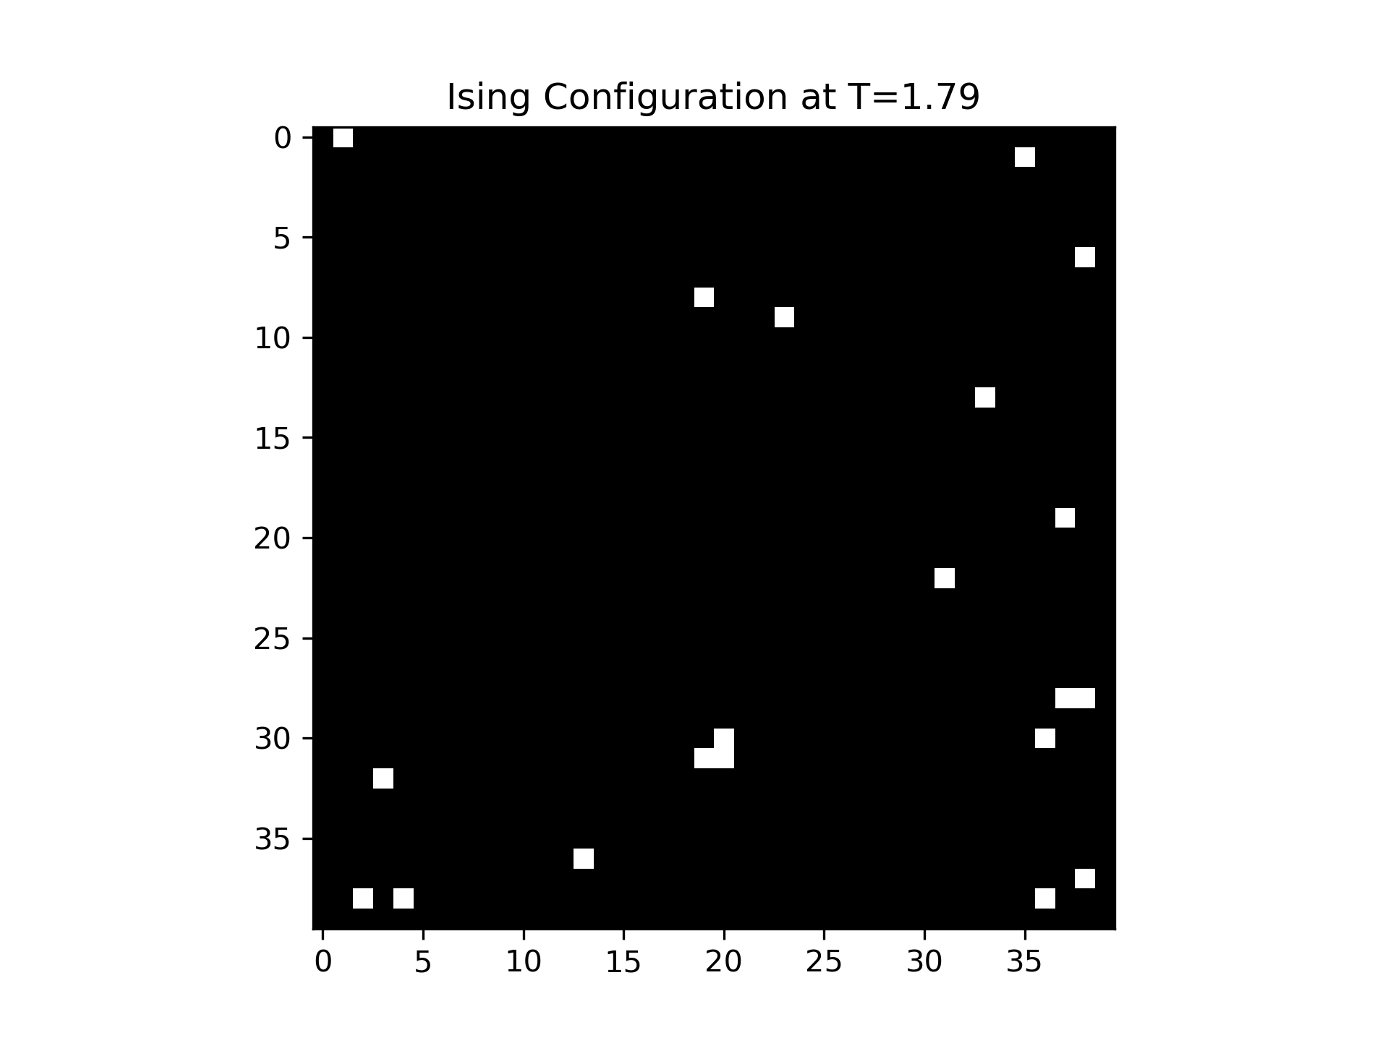
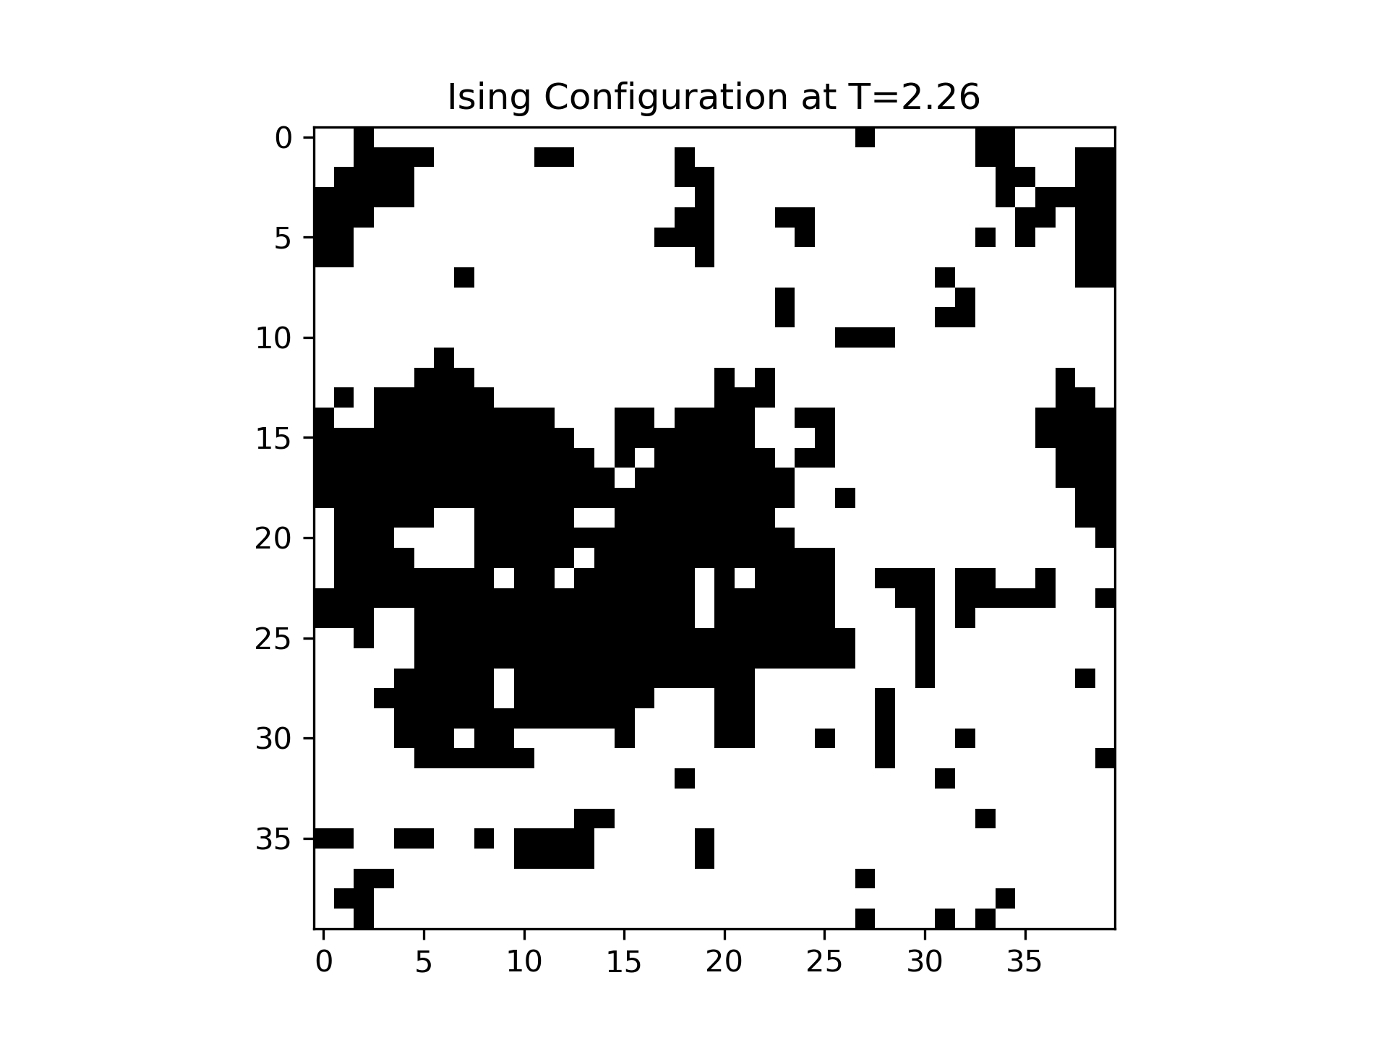
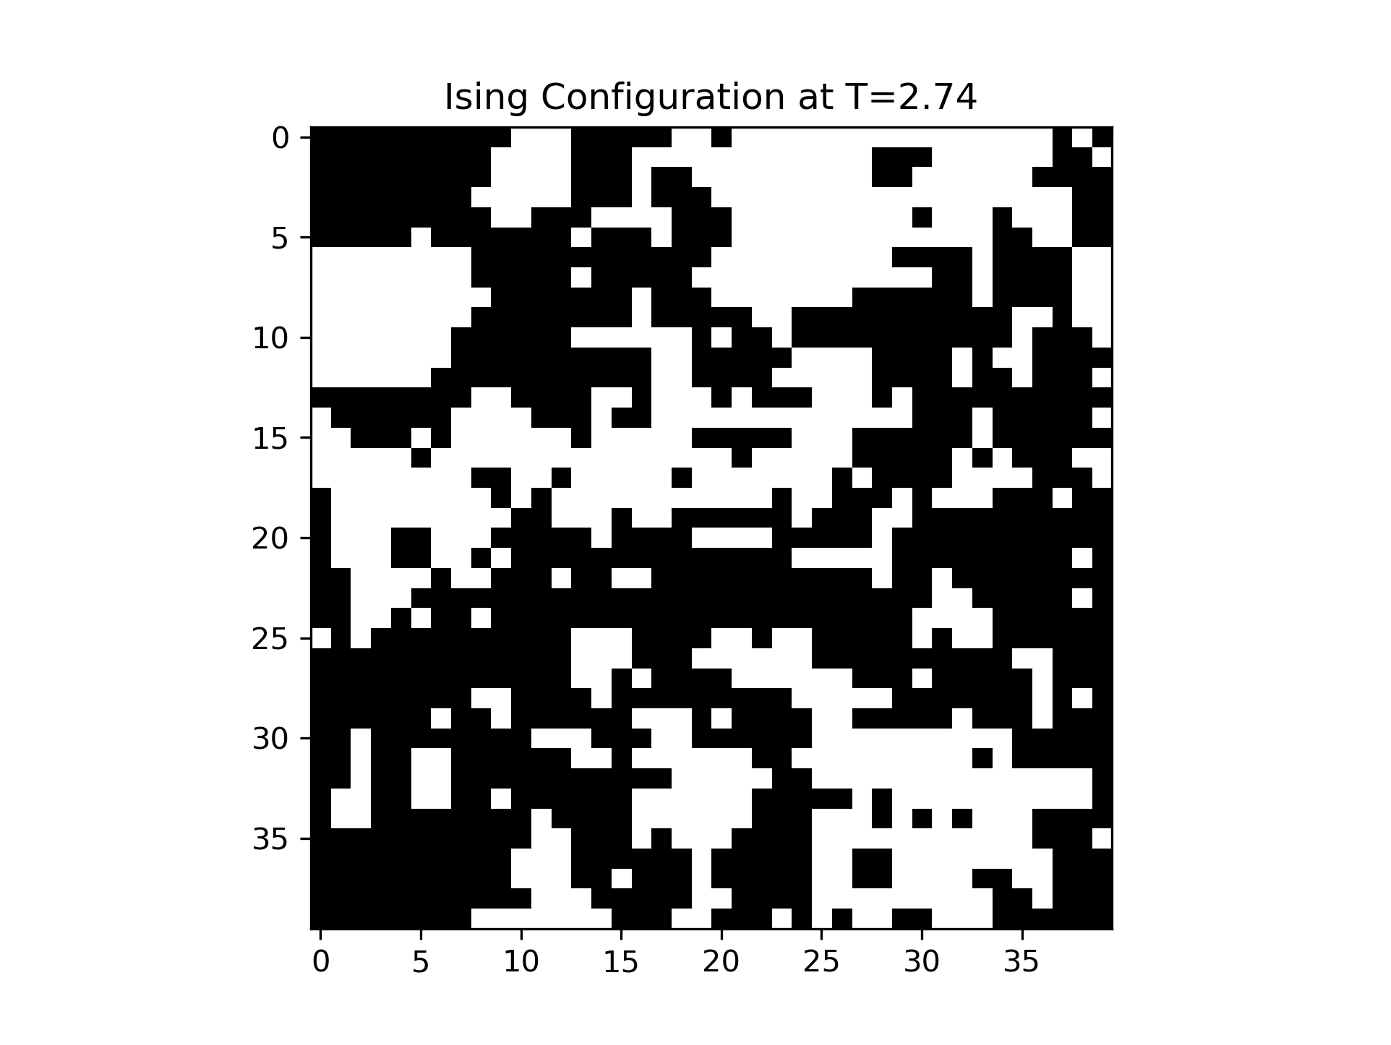



In [ ]:
def visualize_config(temp, critical_temp):
    visualize_temps = [1.79,2.26,2.74]
    for temp in visualize_temps:
        config = np.random.choice([1, -1], size=(N, N))
        for _ in range(thermalization_steps):
            config = metropolis_step(config, 1.0 / temp)  
        plt.imshow(config, cmap='binary', interpolation='nearest')
        plt.title(f'Ising Configuration at T={temp}')
        plt.savefig(f'{temp}_config.png', dpi=300)
        plt.show()  

#critical_temp=2.26

plt.plot(temps, avg_magnetization, 'o-')
plt.xlabel('Temperature')
plt.ylabel('Average Magnetization')
plt.title('2D Square Lattice Ising Model')
plt.text(2.35, 925, 'T$_{c}$=2.26', fontsize=12)
plt.axvline(x=2.26, color ='silver', linestyle=":")
plt.savefig("Square_Lat.png", dpi=300)
plt.show()


for i, temp in enumerate(temps):
    phase = "Ordered" if is_ordered(config, critical_temp) else "Disordered"
    print(f"At Temperature {temp}: {phase} Phase")

    
visualize_config(visualize_temps, critical_temp)